## BigDL Wide & Deep Recommender Demo

Wide and Deep Learning Model, proposed by Google in 2016, is a DNN-Linear mixed model. Wide and deep learning has been used for Google App Store for their app recommendation.

In this tutorial, we'll introduce how to use BigDL to train a wide linear model and a deep neural network, which is called Wide & Deep model. Wide & Deep model combines the strength of memorization and generalization. It's useful for generic large-scale regression and classification problems with sparse input features(e.g., categorical features with a large number of possible feature values).

In [1]:
%pylab inline

import os
import sys
import numpy as np
import pandas as pd
import scipy as sp
import datetime as dt

from bigdl.dataset.transformer import *
from bigdl.dataset.base import *
from bigdl.nn.layer import *
from bigdl.nn.criterion import *
from bigdl.optim.optimizer import *
from bigdl.util.common import *
from utils import *

init_engine()

Populating the interactive namespace from numpy and matplotlib


## 1. Prepare Data
Download training and testing data set from [Census Income Dataset](https://archive.ics.uci.edu/ml/datasets/Census+Income).
Read and parse the dataset into Spark RDD.

In [2]:
train_file_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data'
test_file_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test'

absolutepath='file://' + os.getcwd() + '/'
train_file_name = maybe_download('adult.data', 'census_dataset', train_file_url)
test_file_name = maybe_download('adult.test', 'census_dataset', test_file_url)

train_records = read(absolutepath + train_file_name, sc)
test_records = read(absolutepath + test_file_name, sc)

Training data set has 14 features age, workclass, fnlwgt, etc... and one label income_bracket. There is ten record of the dataset.

In [3]:
pd.DataFrame(train_records.take(10), columns=COLUMNS)

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,gender,capital_gain,capital_loss,hours_per_week,native_country,income_bracket
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
5,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K
6,49,Private,160187,9th,5,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0,0,16,Jamaica,<=50K
7,52,Self-emp-not-inc,209642,HS-grad,9,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,45,United-States,>50K
8,31,Private,45781,Masters,14,Never-married,Prof-specialty,Not-in-family,White,Female,14084,0,50,United-States,>50K
9,42,Private,159449,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,5178,0,40,United-States,>50K


## 2. Transform data to BigDL' Sample
BigDL's Sample is a data structure who represents the features and label of data. So each record will be transform to a BigDL Sample, and BigDL will train the Wide&Deep with these Samples. 

The input BigDL Wide&Deep model required,  are two input tensors, one is SparseTensor for the Wide model, another is a DenseTensor for the Deep model.

In [4]:
def to_sample(row):
    wide_column_shape = np.array([5006])
    wide_column_indices = np.arange(11)
    wide_column_values = np.ones(11)
    gender = categorical_from_vocab_list(row[GENDER], GENDER_VOCAB)
    education = categorical_from_vocab_list(row[EDUCATION], EDUCATION_VOCAB)
    marital_status = categorical_from_vocab_list(row[MARITAL_STATUS], MARITAL_STATUS_VOCAB)
    relationship = categorical_from_vocab_list(row[RELATIONSHIP], RELATIONSHIP_VOCAB)
    workclass = categorical_from_vocab_list(row[WORKCLASS], WORKCLASS_VOCAB)
    
    wide_column_values[0] = gender
    wide_column_values[1] = education
    wide_column_values[2] = marital_status
    wide_column_values[3] = relationship
    wide_column_values[4] = workclass
    
    wide_column_indices[5] = hashbucket(row[OCCUPATION], 1000, 5)
    wide_column_indices[6] = hashbucket(row[NATIVE_COUNTRY], 1000, 1005)
    wide_column_indices[7] = 2005
    wide_column_values[7] = get_boundaries(int(row[AGE]), AGE_BOUNDARIES)
    wide_column_indices[8] = hashbucket(row[EDUCATION] + row[OCCUPATION], 1000, 2006) # 2006
    wide_column_indices[9] = hashbucket(str(row[AGE]) + row[EDUCATION] + row[OCCUPATION], 1000, 3006) # 2006
    wide_column_indices[10] = hashbucket(row[NATIVE_COUNTRY] + row[OCCUPATION], 1000, 4006) # 4006

    deep_column = np.zeros(40)
    deep_column[workclass] = 1
    deep_column[education + 9] = 1
    deep_column[gender + 25] = 1
    deep_column[relationship + 27] = 1
    deep_column[33] = hashbucket(row[NATIVE_COUNTRY], 1000, 1)
    deep_column[34] = hashbucket(row[OCCUPATION], 1000, 1)
    deep_column[35] = row[AGE]
    deep_column[36] = row[EDUCATION_NUM]
    deep_column[37] = row[CAPITAL_GAIN]
    deep_column[38] = row[CAPITAL_LOSS]
    deep_column[39] = row[HOURS_PER_WEEK]
    
    label = get_label(row[LABEL])
    wide_column_values=wide_column_values.astype("float32")
    deep_column=deep_column.astype("float32")

    wide_input = JTensor.sparse(wide_column_values, wide_column_indices, wide_column_shape, bigdl_type="float")
    deep_input = JTensor.from_ndarray(deep_column.reshape(1, 40))
    return Sample.from_jtensor([wide_input, deep_input], label)
    

train_data = train_records.map(lambda line: to_sample(line))
test_data = test_records.map(lambda line: to_sample(line))

Cache the Training and Testing data RDD.

In [5]:
train_data.cache()
print "Total train records: %s" % train_data.count()
test_data.cache()
print "Total test records: %s" % test_data.count()

Total train records: 32561
Total test records: 16281


## 3. Create the Wide&Deep model.

In [6]:
def build_model(class_num = 2):
    model = Sequential()
    wideModel = Identity()
    deepModel = Sequential()
    deepColumn = Concat(2)
    # indicator columns
    deepColumn.add(Sequential().add(Narrow(2, 1, 33)).add(Reshape([33]).set_name("indicator")))
    # native_country 1000
    deepColumn.add(Sequential().add(Select(2, 34)).add(LookupTable(1000, 8, 0.0, 10.0).set_name("embedding_1")))
    # occupation 1000
    deepColumn.add(Sequential().add(Select(2, 35)).add(LookupTable(1000, 8, 0.0, 10.0).set_name("embedding_2")))
    # numeric column
    deepColumn.add(Sequential().add(Narrow(2, 36, 5)).add(Reshape(([5]))))
    deepModel.add(deepColumn)
    deepModel.add(Linear(54, 100).set_name("fc_1")).add(ReLU())
    deepModel.add(Linear(100, 50).set_name("fc_2")).add(ReLU())
    parallel = ParallelTable()
    parallel.add(wideModel)
    parallel.add(deepModel.add(DenseToSparse()))
    model.add(parallel).add(SparseJoinTable(2))
    model.add(SparseLinear(5056, class_num, backwardStart = 5007, backwardLength = 50).set_name("fc_3"))
    model.add(LogSoftMax())
    return model


wide_n_deep=build_model()
print "Wide&Deep model:\n %s" % wide_n_deep

creating: createSequential
creating: createIdentity
creating: createSequential
creating: createConcat
creating: createSequential
creating: createNarrow
creating: createReshape
creating: createSequential
creating: createSelect
creating: createLookupTable
creating: createSequential
creating: createSelect
creating: createLookupTable
creating: createSequential
creating: createNarrow
creating: createReshape
creating: createLinear
creating: createReLU
creating: createLinear
creating: createReLU
creating: createParallelTable
creating: createDenseToSparse
creating: createSparseJoinTable
creating: createSparseLinear
creating: createLogSoftMax
Wide&Deep model:
 Sequential[4d8356d3]{
  [input -> (1) -> (2) -> (3) -> (4) -> output]
  (1): nn.ParallelTable {
	input
	  |`-> (1): Identity[88a7c227]
	   `-> (2): Sequential[7d05aa4a]{
	         [input -> (1) -> (2) -> (3) -> (4) -> (5) -> (6) -> output]
	         (1): Concat[746da37e]{
	           input
	             |`-> (1): Sequential[adccf4a5]{
	  

## 4. Create optimizer and training the model

In [7]:
# Create an Optimizer
batch_size = 100

optimizer = Optimizer(
    model=wide_n_deep,
    training_rdd=train_data,
    criterion=ClassNLLCriterion(),
    optim_method=Adam(learningrate = 0.001, learningrate_decay=0.00005),
    end_trigger=SeveralIteration(2000),
    batch_size=batch_size)

# Set the validation logic
optimizer.set_validation(
    batch_size=batch_size,
    val_rdd=test_data,
    trigger=SeveralIteration(200),
    val_method=[Top1Accuracy(), Loss()]
)
log_dir='/tmp/bigdl_summaries/'
app_name='wide_n_deep-'+dt.datetime.now().strftime("%Y%m%d-%H%M%S")
train_summary = TrainSummary(log_dir=log_dir,
                                     app_name=app_name)
val_summary = ValidationSummary(log_dir=log_dir,
                                        app_name=app_name)
optimizer.set_train_summary(train_summary)
optimizer.set_val_summary(val_summary)
print "saving logs to %s" % (log_dir + app_name)

creating: createClassNLLCriterion
creating: createAdam
creating: createSeveralIteration
creating: createOptimizer
creating: createSeveralIteration
creating: createTop1Accuracy
creating: createClassNLLCriterion
creating: createLoss
creating: createTrainSummary
creating: createValidationSummary
saving logs to /tmp/bigdl_summaries/wide_n_deep-20171030-142256


Train the network. Wait some time till it finished.. Voila! You've got a trained model

In [8]:
%%time
# Boot training process
trained_model = optimizer.optimize()
print "Optimization Done."

Optimization Done.
CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 33.7 s


## 5. Evaluate the trained model
Will return a Top1 Accuracy about 84%.

In [9]:
%%time
evaluate_result=trained_model.evaluate(test_data, 2, [Top1Accuracy()])
print "Top1 accuracy: %s" % evaluate_result[0].result

creating: createTop1Accuracy
Top1 accuracy: 0.842577219009
CPU times: user 8 ms, sys: 0 ns, total: 8 ms
Wall time: 635 ms


## 6. Draw the convergence curve

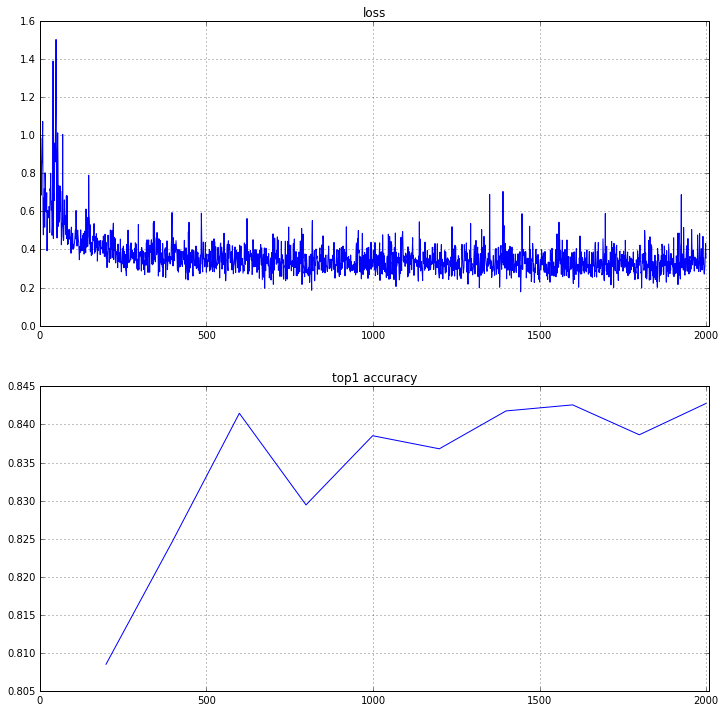

In [10]:
loss = np.array(train_summary.read_scalar("Loss"))
top1 = np.array(val_summary.read_scalar("Top1Accuracy"))

plt.figure(figsize = (12,12))
plt.subplot(2,1,1)
plt.plot(loss[:,0],loss[:,1],label='loss')
plt.xlim(0,loss.shape[0]+10)
plt.grid(True)
plt.title("loss")
plt.subplot(2,1,2)
plt.plot(top1[:,0],top1[:,1],label='top1')
plt.xlim(0,loss.shape[0]+10)
plt.title("top1 accuracy")
plt.grid(True)